df =  0.03125


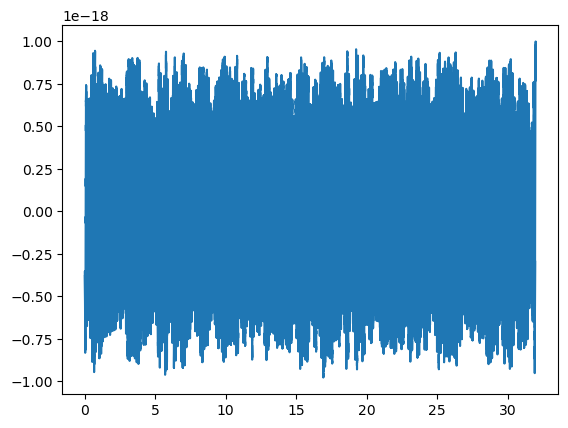

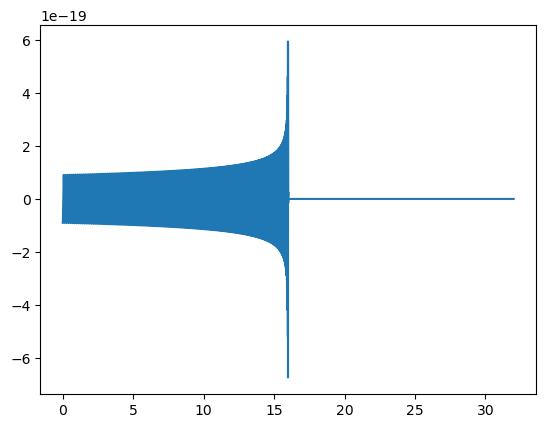

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy.io
from scipy.io import wavfile
from scipy.fft import fft, fftfreq, ifft
from scipy.signal import welch, periodogram
import h5py
from scipy import signal
from scipy import interpolate
from scipy.signal import butter, lfilter


# reading data
strain_data = pd.read_csv('dati_H1_32s_progetto_3.txt', sep=' ', names=['strain_data'])['strain_data']
# reading template
strain_template = pd.read_csv('GW170104_4_template.txt', sep=' ', names=['strain_template'])['strain_template']

# Settiamo le variabili T ed N, dove T è il tempo di acquisizione in secondi(32 dato dalla specifica) 
# e N è il numero di righe dei dati della specifica (131072)
T = 32
N = len(strain_data)

# calcolo la frequenza di acquisizione (4096Hz)
fs = N / T
# calcolo l'intervallo temporale di acquisizione (0.000244140625s)
dt = 1./fs

# creo l'array del tempo, cioé un array che parte da 0, e crea gli elementi 
# successivi aggiungendo il valore "dt" ai precedenti fino a raggiungere il valore di T
# quindi stiamo creando l'asse x per il grafico dove ogni punto è il momento in cui è 
# stato campionato il segnale. Avremo quindi 131072 punti.
time = np.arange(0, T, dt)
# Questa è la risoluzione in frequenza
df = 1/T
print('df = ',df)
# Facciamo il plot dei dati
plt.plot(time, strain_data)
plt.show()

# Settiamo un Ns diverso se vogliamo accorciare la finestra del segnale
Ns = N
# Plottiamo il segnale del template
plt.plot(time[:Ns], strain_template[:Ns])
plt.show()

Notiamo che abbiamo un segnale che è come quello di un'onda gravitazionale, ed è situato nella prima metà dei dati che includono il noise